# PMR3508-2024-70

Classification of Adult Database (from Kaggle) using k-Nearest Neighbor (kNN)

This Notebook is divided in the following sections:
1. Exploratory Analysis
2. Classifier Development

First, we import the libraries that we're going to use

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Then, we import the Adult dataset into a Pandas DataFrame.

In [207]:
df = pd.read_csv('data/train_data.csv')
df.set_index('Id', inplace=True)
print()

## 1. Exploratory Analysis

### 1.1 Data Understanding

In this subsection, we take a first look at the dataset to gain some insights of the data.


In [208]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [209]:
df.shape

(32560, 15)

Number of columns is actually 15 if we don't count the Id column, we'll set it as the index later

In [210]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

Objects type are strings that have to be processed with one-hot encoding so we can use it to train our models.

To get a quick overview of some statistics of the numerical features of our dataframe, we use the describe method.

In [211]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### 1.2 Data Preparation
- Rename columns
- Drop irrelevant columns and rows
- Identify duplicated rows

First, we rename the columns for better visualization

In [214]:
df.rename(columns={'age': 'Age',
                   'workclass': 'Workclass',
                   'fnlwgt': 'FinalWeight',
                   'education': 'Education',
                   'education.num': 'Education Number',
                   'marital.status': 'Maritial Status',
                   'occupation': 'Occupation',
                   'relationship': 'Relationship',
                   'race': 'Race',
                   'sex': 'Sex',
                   'capital.gain': 'Capital Gain',
                   'capital.loss': 'Capital Loss',
                   'hours.per.week': 'Hours per Week',
                   'native.country': 'Native Country',
                   'income': 'Target'
                   }, inplace=True)
df.head()

,Age,Workclass,FinalWeight,Education,Education Number,Maritial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Target
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


Now we remove rows with missing data

In [215]:
df.replace("?", np.nan, inplace=True)

In [216]:
df.isna().sum()

Age                    0
Workclass           1836
FinalWeight            0
Education              0
Education Number       0
Maritial Status        0
Occupation          1843
Relationship           0
Race                   0
Sex                    0
Capital Gain           0
Capital Loss           0
Hours per Week         0
Native Country       583
Target                 0
dtype: int64

In [217]:
df = df.dropna()
df.shape

(30161, 15)

Now we identify duplicated rows

In [219]:
df.duplicated().sum()

23

Each row represents a person and it is possible that two people have the same census data, however this is unlikely to happen. So we'll choose to exclude this duplicated data.

In [220]:
df.drop_duplicates(inplace=True)
df.duplicated().sum() # to verify if duplicated values were excluded

0

### 1.3 Feature Understanding

Plot of features distributions to gain more insights. We'll start with personal-related features.

In [221]:
df.head()

,Age,Workclass,FinalWeight,Education,Education Number,Maritial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Target
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


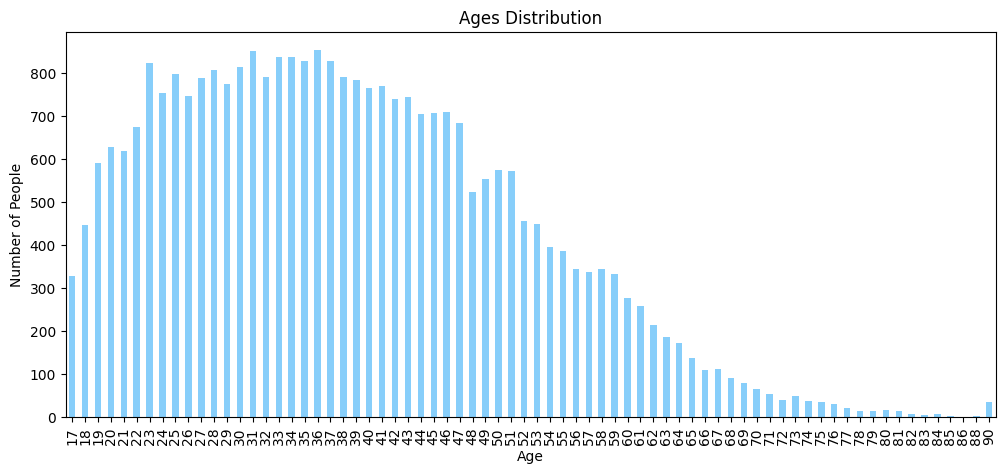

In [241]:
# Feature: Age
plt.figure(figsize=(12,5))
df['Age'].value_counts().sort_index().plot(kind="bar", color='lightskyblue')
plt.title("Ages Distribution")
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.show()

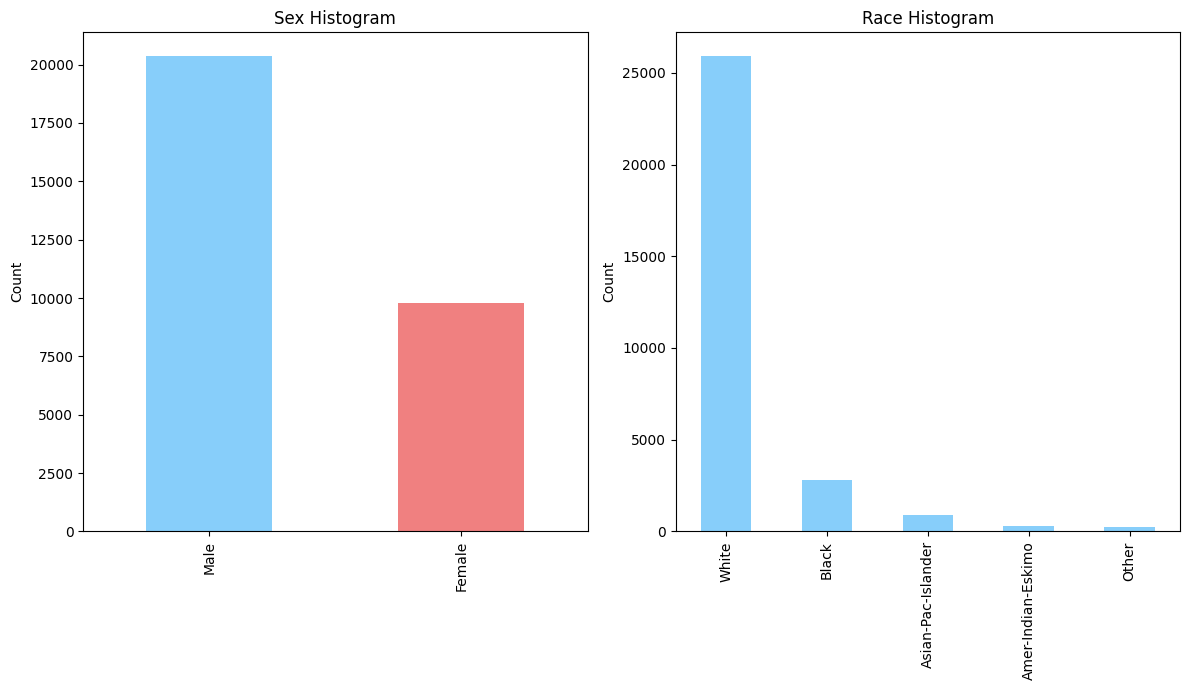

In [256]:
# Features: Sex and Race
sex_list = df['Sex'].value_counts()
race_list = df['Race'].value_counts()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 7))

# First subplot
sex_list.plot(kind='bar', ax=ax1, color=['lightskyblue', 'lightcoral'])
ax1.set_title('Sex Histogram')
ax1.set_ylabel('Count')
ax1.set_xlabel('')

# Second subplot
race_list.plot(kind='bar', ax=ax2, color='lightskyblue')
ax2.set_title('Race Histogram')
ax2.set_ylabel('Count')
ax2.set_xlabel('')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

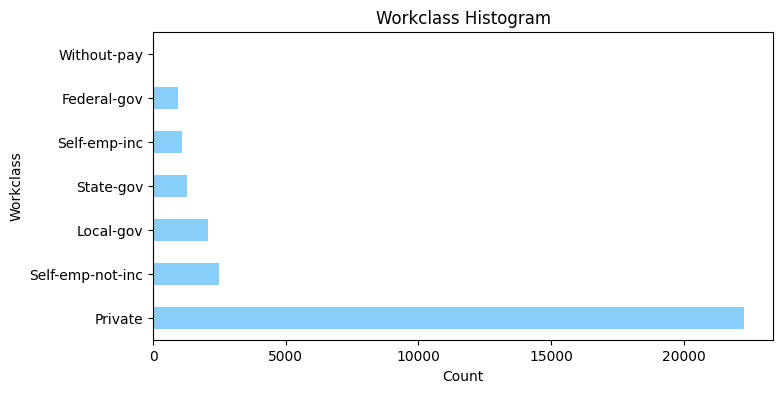

In [243]:
# Feature: Workclass
plt.figure(figsize=(8,4))
workclass_list = df['Workclass'].value_counts()
workclass_list.plot(kind="barh", color='lightskyblue')
plt.title("Workclass Histogram")
plt.xlabel("Count")
plt.show()

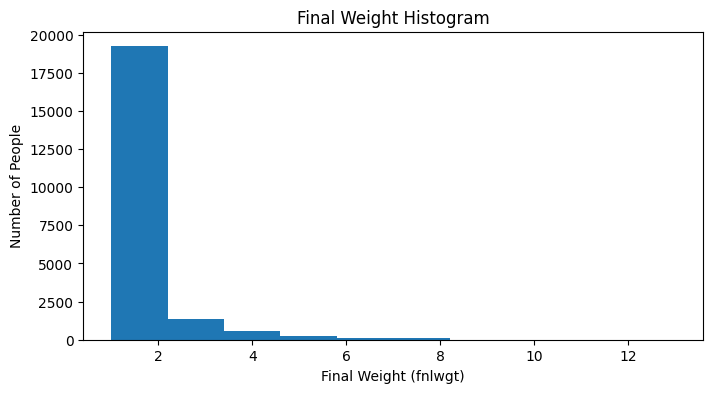

In [ ]:
# Feature: Final Weight (fnlwgt)
plt.figure(figsize=(8,4))
df['fnlwgt'].value_counts().plot(kind="hist", color=)
plt.title("Final Weight Histogram")
plt.xlabel("Final Weight (fnlwgt)")
plt.ylabel("Number of People")
plt.show()

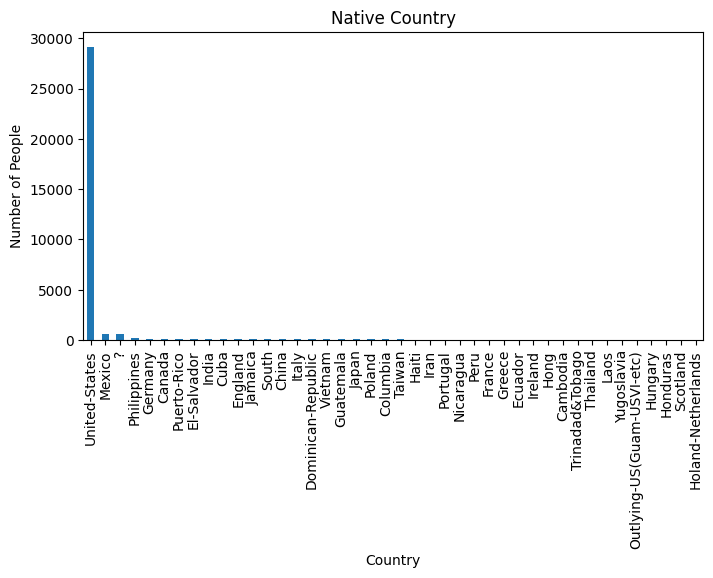

In [ ]:
# Feature: Final Weight (fnlwgt)
plt.figure(figsize=(8,4))
df['native.country'].value_counts().plot(kind="bar")
plt.title("Native Country")
plt.xlabel("Country")
plt.ylabel("Number of People")
plt.show()

plt.figure(figsize=())